In [1]:
# !pip install cartopy clouddrift cmocean matplotlib numpy s3fs xarray

In [2]:
import cartopy.crs as ccrs
import clouddrift as cd
import cmocean.cm as cmo
import numpy as np
import matplotlib.pyplot as plt
import s3fs
import xarray as xr

## Access EDITO s3

In [3]:
s3 = s3fs.S3FileSystem(
  anon=True,
  endpoint_url="https://minio.lab.dive.edito.eu"
)

In [4]:
s3.ls("/oidc-bertrava/data")

['oidc-bertrava/data/4dvarnet.zarr',
 'oidc-bertrava/data/duacs.zarr',
 'oidc-bertrava/data/gdp6h.zarr',
 'oidc-bertrava/data/miost.zarr',
 'oidc-bertrava/data/vardyn.zarr']

## Sea surface currents

### DUACS

In [5]:
duacs_store = s3fs.S3Map(root=f"s3://oidc-bertrava/data/duacs.zarr", s3=s3)

In [6]:
duacs_ds = xr.open_zarr(duacs_store)
duacs_ds

<xarray.Dataset> Size: 79MB
Dimensions:    (time: 117, latitude: 100, longitude: 280)
Coordinates:
  * latitude   (latitude) float32 400B 25.12 25.38 25.62 ... 49.38 49.62 49.88
  * longitude  (longitude) float32 1kB -79.88 -79.62 -79.38 ... -10.38 -10.12
  * time       (time) datetime64[ns] 936B 2023-07-27 2023-07-28 ... 2023-11-20
Data variables:
    adt        (time, latitude, longitude) float64 26MB dask.array<chunksize=(1, 100, 280), meta=np.ndarray>
    ugos       (time, latitude, longitude) float64 26MB dask.array<chunksize=(1, 100, 280), meta=np.ndarray>
    vgos       (time, latitude, longitude) float64 26MB dask.array<chunksize=(1, 100, 280), meta=np.ndarray>
Attributes: (12/45)
    Conventions:                     CF-1.6
    Metadata_Conventions:            Unidata Dataset Discovery v1.0
    cdm_data_type:                   Grid
    comment:                         Sea Surface Height measured by Altimetry...
    contact:                         servicedesk.cmems@mercator-ocean.eu
    copernicusmarine_version:        1.3.2
    ...                              ...
    summary:                         SSALTO/DUACS Near-Real-Time Level-4 sea ...
    time_coverage_duration:          P1D
    time_coverage_end:               2023-11-24T12:00:00Z
    time_coverage_resolution:        P1D
    time_coverage_start:             2023-11-23T12:00:00Z
    title:                           NRT merged all satellites Global Ocean G...

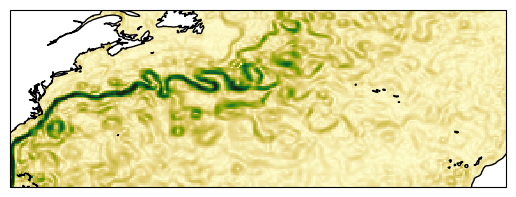

In [7]:
ssc_snap = duacs_ds.sel(time="2023-08-01")

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())

im = ax.pcolormesh(
    ssc_snap.longitude,
    ssc_snap.latitude,
    np.sqrt(ssc_snap.ugos ** 2 + ssc_snap.vgos ** 2).compute(),
    cmap=cmo.speed,
    vmin=0,
    vmax=1.5,
    shading="auto",
    transform=ccrs.PlateCarree()
)

ax.coastlines()

plt.show()

### MIOST

In [8]:
miost_store = s3fs.S3Map(root=f"s3://oidc-bertrava/data/miost.zarr", s3=s3)

In [9]:
miost_ds = xr.open_zarr(miost_store)
miost_ds

<xarray.Dataset> Size: 1GB
Dimensions:             (time: 144, latitude: 251, longitude: 700, bounds: 2)
Coordinates:
  * latitude            (latitude) float32 1kB 25.0 25.1 25.2 ... 49.8 49.9 50.0
    latitude_bounds     (latitude, bounds) float64 4kB dask.array<chunksize=(251, 2), meta=np.ndarray>
  * longitude           (longitude) float64 6kB 280.0 280.1 ... 349.8 349.9
    longitude_bounds    (longitude, bounds) float64 11kB dask.array<chunksize=(700, 2), meta=np.ndarray>
  * time                (time) datetime64[ns] 1kB 2023-07-10 ... 2023-11-30
Dimensions without coordinates: bounds
Data variables:
    adt                 (time, latitude, longitude) float64 202MB dask.array<chunksize=(1, 251, 700), meta=np.ndarray>
    relative_vorticity  (time, latitude, longitude) float64 202MB dask.array<chunksize=(1, 251, 700), meta=np.ndarray>
    sla                 (time, latitude, longitude) float64 202MB dask.array<chunksize=(1, 251, 700), meta=np.ndarray>
    ugos                (time, latitude, longitude) float64 202MB dask.array<chunksize=(1, 251, 700), meta=np.ndarray>
    ugosa               (time, latitude, longitude) float64 202MB dask.array<chunksize=(1, 251, 700), meta=np.ndarray>
    vgos                (time, latitude, longitude) float64 202MB dask.array<chunksize=(1, 251, 700), meta=np.ndarray>
    vgosa               (time, latitude, longitude) float64 202MB dask.array<chunksize=(1, 251, 700), meta=np.ndarray>
Attributes: (12/45)
    Conventions:                     CF-1.6
    Metadata_Conventions:            Unidata Dataset Discovery v1.0
    cdm_data_type:                   Grid
    comment:                         Sea Surface Height measured by Altimetry...
    contact:                         
    creator_email:                   
    ...                              ...
    summary:                         Experimental SSALTO/DUACS Delayed-Time L...
    time_coverage_duration:          P1D
    time_coverage_end:               2023-07-10T12:00:00Z
    time_coverage_resolution:        P1D
    time_coverage_start:             2023-07-10T12:00:00Z
    title:                           DT merged all satellites Global Ocean Gr...

Longitudes range from 0° to 360°: need to transform them to work in [-180°, 180°].

In [10]:
miost_ds["longitude"] = (miost_ds["longitude"] + 180) % 360 - 180
miost_ds

<xarray.Dataset> Size: 1GB
Dimensions:             (time: 144, latitude: 251, longitude: 700, bounds: 2)
Coordinates:
  * latitude            (latitude) float32 1kB 25.0 25.1 25.2 ... 49.8 49.9 50.0
    latitude_bounds     (latitude, bounds) float64 4kB dask.array<chunksize=(251, 2), meta=np.ndarray>
  * longitude           (longitude) float64 6kB -80.0 -79.9 ... -10.2 -10.1
    longitude_bounds    (longitude, bounds) float64 11kB dask.array<chunksize=(700, 2), meta=np.ndarray>
  * time                (time) datetime64[ns] 1kB 2023-07-10 ... 2023-11-30
Dimensions without coordinates: bounds
Data variables:
    adt                 (time, latitude, longitude) float64 202MB dask.array<chunksize=(1, 251, 700), meta=np.ndarray>
    relative_vorticity  (time, latitude, longitude) float64 202MB dask.array<chunksize=(1, 251, 700), meta=np.ndarray>
    sla                 (time, latitude, longitude) float64 202MB dask.array<chunksize=(1, 251, 700), meta=np.ndarray>
    ugos                (time, latitude, longitude) float64 202MB dask.array<chunksize=(1, 251, 700), meta=np.ndarray>
    ugosa               (time, latitude, longitude) float64 202MB dask.array<chunksize=(1, 251, 700), meta=np.ndarray>
    vgos                (time, latitude, longitude) float64 202MB dask.array<chunksize=(1, 251, 700), meta=np.ndarray>
    vgosa               (time, latitude, longitude) float64 202MB dask.array<chunksize=(1, 251, 700), meta=np.ndarray>
Attributes: (12/45)
    Conventions:                     CF-1.6
    Metadata_Conventions:            Unidata Dataset Discovery v1.0
    cdm_data_type:                   Grid
    comment:                         Sea Surface Height measured by Altimetry...
    contact:                         
    creator_email:                   
    ...                              ...
    summary:                         Experimental SSALTO/DUACS Delayed-Time L...
    time_coverage_duration:          P1D
    time_coverage_end:               2023-07-10T12:00:00Z
    time_coverage_resolution:        P1D
    time_coverage_start:             2023-07-10T12:00:00Z
    title:                           DT merged all satellites Global Ocean Gr...

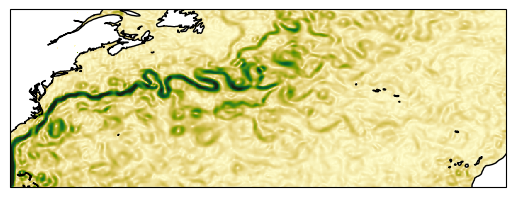

In [11]:
ssc_snap = miost_ds.sel(time="2023-08-01")

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())

im = ax.pcolormesh(
    ssc_snap.longitude,
    ssc_snap.latitude,
    np.sqrt(ssc_snap.ugos ** 2 + ssc_snap.vgos ** 2).compute(),
    cmap=cmo.speed,
    vmin=0,
    vmax=1.5,
    shading="auto",
    transform=ccrs.PlateCarree()
)

ax.coastlines()

plt.show()

### VarDyn

In [12]:
vardyn_store = s3fs.S3Map(root=f"s3://oidc-bertrava/data/vardyn.zarr", s3=s3)

In [13]:
vardyn_ds = xr.open_zarr(vardyn_store)
vardyn_ds

<xarray.Dataset> Size: 4GB
Dimensions:             (time: 465, latitude: 276, longitude: 600)
Coordinates:
  * latitude            (latitude) float32 1kB 25.0 25.09 25.18 ... 49.91 50.0
  * longitude           (longitude) float64 5kB 280.0 280.1 ... 349.8 349.9
  * time                (time) datetime64[ns] 4kB 2023-07-27 ... 2023-11-20
Data variables:
    adt                 (time, latitude, longitude) float64 616MB dask.array<chunksize=(1, 276, 600), meta=np.ndarray>
    relative_vorticity  (time, latitude, longitude) float64 616MB dask.array<chunksize=(1, 276, 600), meta=np.ndarray>
    sla                 (time, latitude, longitude) float64 616MB dask.array<chunksize=(1, 276, 600), meta=np.ndarray>
    ugos                (time, latitude, longitude) float64 616MB dask.array<chunksize=(1, 276, 600), meta=np.ndarray>
    ugosa               (time, latitude, longitude) float64 616MB dask.array<chunksize=(1, 276, 600), meta=np.ndarray>
    vgos                (time, latitude, longitude) float64 616MB dask.array<chunksize=(1, 276, 600), meta=np.ndarray>
    vgosa               (time, latitude, longitude) float64 616MB dask.array<chunksize=(1, 276, 600), meta=np.ndarray>

Longitudes range from 0° to 360°: need to transform them to work in [-180°, 180°].

In [14]:
vardyn_ds["longitude"] = (vardyn_ds["longitude"] + 180) % 360 - 180
vardyn_ds

<xarray.Dataset> Size: 4GB
Dimensions:             (time: 465, latitude: 276, longitude: 600)
Coordinates:
  * latitude            (latitude) float32 1kB 25.0 25.09 25.18 ... 49.91 50.0
  * longitude           (longitude) float64 5kB -79.98 -79.86 ... -10.22 -10.11
  * time                (time) datetime64[ns] 4kB 2023-07-27 ... 2023-11-20
Data variables:
    adt                 (time, latitude, longitude) float64 616MB dask.array<chunksize=(1, 276, 600), meta=np.ndarray>
    relative_vorticity  (time, latitude, longitude) float64 616MB dask.array<chunksize=(1, 276, 600), meta=np.ndarray>
    sla                 (time, latitude, longitude) float64 616MB dask.array<chunksize=(1, 276, 600), meta=np.ndarray>
    ugos                (time, latitude, longitude) float64 616MB dask.array<chunksize=(1, 276, 600), meta=np.ndarray>
    ugosa               (time, latitude, longitude) float64 616MB dask.array<chunksize=(1, 276, 600), meta=np.ndarray>
    vgos                (time, latitude, longitude) float64 616MB dask.array<chunksize=(1, 276, 600), meta=np.ndarray>
    vgosa               (time, latitude, longitude) float64 616MB dask.array<chunksize=(1, 276, 600), meta=np.ndarray>

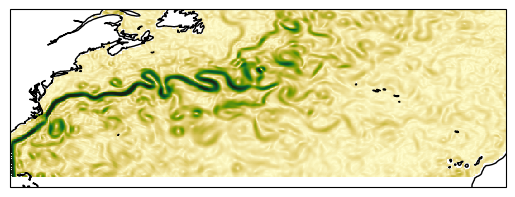

In [15]:
ssc_snap = vardyn_ds.sel(time="2023-08-01")

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())

im = ax.pcolormesh(
    ssc_snap.longitude,
    ssc_snap.latitude,
    np.sqrt(ssc_snap.ugos[0] ** 2 + ssc_snap.vgos[0] ** 2).compute(),
    cmap=cmo.speed,
    vmin=0,
    vmax=1.5,
    shading="auto",
    transform=ccrs.PlateCarree()
)

ax.coastlines()

plt.show()

### 4dVarNet

In [16]:
fdvarnet_store = s3fs.S3Map(root=f"s3://oidc-bertrava/data/4dvarnet.zarr", s3=s3)

In [17]:
fdvarnet_ds = xr.open_zarr(fdvarnet_store)
fdvarnet_ds

<xarray.Dataset> Size: 738MB
Dimensions:             (time: 117, latitude: 201, longitude: 560, bounds: 2)
Coordinates:
  * latitude            (latitude) float32 804B 25.0 25.12 25.25 ... 49.88 50.0
    latitude_bounds     (latitude, bounds) float64 3kB dask.array<chunksize=(201, 2), meta=np.ndarray>
  * longitude           (longitude) float64 4kB 280.0 280.1 ... 349.8 349.9
    longitude_bounds    (longitude, bounds) float64 9kB dask.array<chunksize=(560, 2), meta=np.ndarray>
  * time                (time) datetime64[ns] 936B 2023-07-27 ... 2023-11-20
Dimensions without coordinates: bounds
Data variables:
    adt                 (time, latitude, longitude) float64 105MB dask.array<chunksize=(1, 201, 560), meta=np.ndarray>
    relative_vorticity  (time, latitude, longitude) float64 105MB dask.array<chunksize=(1, 201, 560), meta=np.ndarray>
    sla                 (time, latitude, longitude) float64 105MB dask.array<chunksize=(1, 201, 560), meta=np.ndarray>
    ugos                (time, latitude, longitude) float64 105MB dask.array<chunksize=(1, 201, 560), meta=np.ndarray>
    ugosa               (time, latitude, longitude) float64 105MB dask.array<chunksize=(1, 201, 560), meta=np.ndarray>
    vgos                (time, latitude, longitude) float64 105MB dask.array<chunksize=(1, 201, 560), meta=np.ndarray>
    vgosa               (time, latitude, longitude) float64 105MB dask.array<chunksize=(1, 201, 560), meta=np.ndarray>
Attributes: (12/45)
    Conventions:                     CF-1.6
    Metadata_Conventions:            Unidata Dataset Discovery v1.0
    cdm_data_type:                   Grid
    comment:                         Sea Surface Height measured by Altimetry...
    contact:                         
    creator_email:                   
    ...                              ...
    summary:                         Experimental SSALTO/DUACS Delayed-Time L...
    time_coverage_duration:          P1D
    time_coverage_end:               2023-07-27T12:00:00Z
    time_coverage_resolution:        P1D
    time_coverage_start:             2023-07-27T12:00:00Z
    title:                           DT merged all satellites North Atlantic ...

Longitudes range from 0° to 360°: need to transform them to work in [-180°, 180°].

In [18]:
fdvarnet_ds["longitude"] = (fdvarnet_ds["longitude"] + 180) % 360 - 180
fdvarnet_ds

<xarray.Dataset> Size: 738MB
Dimensions:             (time: 117, latitude: 201, longitude: 560, bounds: 2)
Coordinates:
  * latitude            (latitude) float32 804B 25.0 25.12 25.25 ... 49.88 50.0
    latitude_bounds     (latitude, bounds) float64 3kB dask.array<chunksize=(201, 2), meta=np.ndarray>
  * longitude           (longitude) float64 4kB -80.0 -79.88 ... -10.25 -10.12
    longitude_bounds    (longitude, bounds) float64 9kB dask.array<chunksize=(560, 2), meta=np.ndarray>
  * time                (time) datetime64[ns] 936B 2023-07-27 ... 2023-11-20
Dimensions without coordinates: bounds
Data variables:
    adt                 (time, latitude, longitude) float64 105MB dask.array<chunksize=(1, 201, 560), meta=np.ndarray>
    relative_vorticity  (time, latitude, longitude) float64 105MB dask.array<chunksize=(1, 201, 560), meta=np.ndarray>
    sla                 (time, latitude, longitude) float64 105MB dask.array<chunksize=(1, 201, 560), meta=np.ndarray>
    ugos                (time, latitude, longitude) float64 105MB dask.array<chunksize=(1, 201, 560), meta=np.ndarray>
    ugosa               (time, latitude, longitude) float64 105MB dask.array<chunksize=(1, 201, 560), meta=np.ndarray>
    vgos                (time, latitude, longitude) float64 105MB dask.array<chunksize=(1, 201, 560), meta=np.ndarray>
    vgosa               (time, latitude, longitude) float64 105MB dask.array<chunksize=(1, 201, 560), meta=np.ndarray>
Attributes: (12/45)
    Conventions:                     CF-1.6
    Metadata_Conventions:            Unidata Dataset Discovery v1.0
    cdm_data_type:                   Grid
    comment:                         Sea Surface Height measured by Altimetry...
    contact:                         
    creator_email:                   
    ...                              ...
    summary:                         Experimental SSALTO/DUACS Delayed-Time L...
    time_coverage_duration:          P1D
    time_coverage_end:               2023-07-27T12:00:00Z
    time_coverage_resolution:        P1D
    time_coverage_start:             2023-07-27T12:00:00Z
    title:                           DT merged all satellites North Atlantic ...

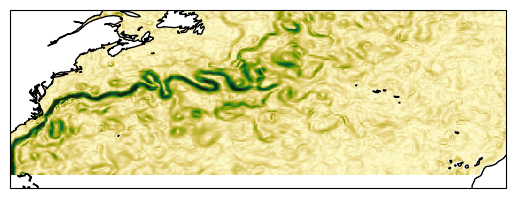

In [19]:
ssc_snap = fdvarnet_ds.sel(time="2023-08-01")

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())

im = ax.pcolormesh(
    ssc_snap.longitude,
    ssc_snap.latitude,
    np.sqrt(ssc_snap.ugos ** 2 + ssc_snap.vgos ** 2).compute(),
    cmap=cmo.speed,
    vmin=0,
    vmax=1.5,
    shading="auto",
    transform=ccrs.PlateCarree()
)

ax.coastlines()

plt.show()

### GDP Drifters

MIOST, VarDyn, 4dVarNet datasets from Aviso+ start at 2023-07-27: we will have to use the GDP6H dataset.

In [20]:
gdp6h_store = s3fs.S3Map(root=f"s3://oidc-bertrava/data/gdp6h.zarr", s3=s3)

In [21]:
ds_gdp6h = xr.open_zarr(gdp6h_store)
ds_gdp6h

<xarray.Dataset> Size: 2GB
Dimensions:                (traj: 27647, obs: 46535470)
Coordinates:
    id                     (traj) int64 221kB dask.array<chunksize=(27647,), meta=np.ndarray>
    time                   (obs) datetime64[ns] 372MB dask.array<chunksize=(181780,), meta=np.ndarray>
Dimensions without coordinates: traj, obs
Data variables: (12/49)
    BuoyTypeManufacturer   (traj) |S20 553kB dask.array<chunksize=(13824,), meta=np.ndarray>
    BuoyTypeSensorArray    (traj) |S20 553kB dask.array<chunksize=(13824,), meta=np.ndarray>
    CurrentProgram         (traj) float64 221kB dask.array<chunksize=(27647,), meta=np.ndarray>
    DeployingCountry       (traj) |S20 553kB dask.array<chunksize=(13824,), meta=np.ndarray>
    DeployingShip          (traj) |S20 553kB dask.array<chunksize=(13824,), meta=np.ndarray>
    DeploymentComments     (traj) |S20 553kB dask.array<chunksize=(13824,), meta=np.ndarray>
    ...                     ...
    start_lon              (traj) float32 111kB dask.array<chunksize=(27647,), meta=np.ndarray>
    temp                   (obs) float32 186MB dask.array<chunksize=(363559,), meta=np.ndarray>
    typebuoy               (traj) |S10 276kB dask.array<chunksize=(13824,), meta=np.ndarray>
    typedeath              (traj) int8 28kB dask.array<chunksize=(27647,), meta=np.ndarray>
    ve                     (obs) float32 186MB dask.array<chunksize=(363559,), meta=np.ndarray>
    vn                     (obs) float32 186MB dask.array<chunksize=(363559,), meta=np.ndarray>
Attributes: (12/18)
    Conventions:          CF-1.6
    acknowledgement:      Lumpkin, Rick; Centurioni, Luca (2019). NOAA Global...
    contributor_name:     NOAA Global Drifter Program
    contributor_role:     Data Acquisition Center
    date_created:         2024-04-04T13:44:01.176967
    doi:                  10.25921/7ntx-z961
    ...                   ...
    publisher_name:       GDP Drifter DAC
    publisher_url:        https://www.aoml.noaa.gov/phod/gdp
    summary:              Global Drifter Program six-hourly data
    time_coverage_end:    2023-10-18:18:00:00Z
    time_coverage_start:  1979-02-15:00:00:00Z
    title:                Global Drifter Program drifting buoy collection

In [ ]:
ds_drifters = cd.ragged.subset(
    ds_gdp6h, 
    {
        "time": lambda t: (t >= np.datetime64("2023-07-27")) & (t <= np.datetime64("2023-11-20")),
        "lat": lambda l: (l >= 25) & (l <= 50),
        "lon": lambda l: (l >= -80) & (l <= -10)
    }, 
    row_dim_name="traj"
)
ds_drifters

In [ ]:
fig = plt.figure()

ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())

ax.scatter(
    ds_drifters.lon,
    ds_drifters.lat,
    transform=ccrs.PlateCarree(),
    s=0.5
)

ax.coastlines()
ax.gridlines(draw_labels=True)